<a href="https://colab.research.google.com/github/mcjauregui72/CNN_MedImageClassification/blob/main/SubmodelsEnsembleChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Two Functional Models (Pretrained and Custom): Trained and Evaluated Individually, as an Ensemble, and Chained



## Import dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import os
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout, Rescaling, BatchNormalization
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Image module from Python Imaging Library (PIL) for opening, manipulating, and saving image file formats
Allows performing various operations like opening, resizing, cropping, enhancing, saving images, creating Image objects, loading images from files, manipulating images, performing image processing tasks


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

## Initialize dictionary to store images

In [ ]:
images = {}

## (1) Iterate over each tuple returned by os.walk( ), (2) Read image file using OpenCV (cv2), (3) Convert color space from BGR to RGB, (4) Store in { } where file name serves as key  
  
Store converted image ('img_rgb'), a NumPy array containing image's pixel data, as value in { } key-value pairs  
When images stored in { } with filenames as keys (images[file] = img_rgb), value associated with each key (filename) is image data itself  
'file' variable acts as key in { } key-value pairs  
Each unique file (filename) as key ensures entries are unique in { } (reusing filename would overwrite previous value associated with key)  

In [ ]:
for root, _, files in os.walk(base_dir):          # root is base_dir, _ is placeholder for directories in root
    for file in files:                            # 'files'= list of files in root
        if file.endswith('.png'):                 # Check file ending to filter only PNG files
            file_path = os.path.join(root, file)  # Construct full path to (PNG) file by joining root path with file name

            img = cv2.imread(file_path)                         # Read image from specified file path and return it as NumPy array ('img')
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Array in BGR format by default, Convert to RGB format to display correctly with Matplotlib

            images[file] = img_rgb   # tells Python to add or update an entry in images []


dictionary[file] = value   is syntax for assigning value ('img_rgb') to specific key ('file') within initialized { } called 'images'  
"[ ]" used to access or assign values via keys inside a { }  
Assigning value to key = “Inside this { }, use value of file as key, and set its value”  
dictionary[file] is syntactically equivalent to dictionary.__getitem__(file)  
{ } only used to define dictionary literals or sets, not for indexing or assignment (which is role of [ ])

##Print string representation of dict_keys view object to include 'dict_keys' followed by list of keys  
dict_keys view object is result of calling .keys() on a { }  
Dynamic view of { }’s keys, reflects real-time changes to { }, behaves like set-like iterable, is memory-efficient (doesn’t create new list)  

dict_keys(['000115 (5).png', '000115.png', '000116 (5).png', '000109 (3).png', '000116 (9).png', '000114.png', '000115 (2).png', '000112 (2).png', '000116 (3).png', '000113 (3).png', '000115 (9).png', '000117.png', '000112 (9).png', '000109 (8).png', '000108 (8).png', '000110 (7).png', '000109 (4).png', '000108 (7).png', '000113.png', '000114 (10).png', '000116 (8).png', '000117 (6).png', '000111 (2).png', '004162_01_01_150.png', '4 (2).png', '004007_01_01_519.png', '003828_02_01_174.png', '8 - Copy (3).png', '4 - Copy (2).png', '7.png', '6 - Copy.png', '6 - Copy (2) - Copy.png', '7 - Copy (3).png', '5.png', '6 - Copy (3).png', '7 - Copy (2).png', '000110.png', '000128.png', '000120.png', '000130.png', '000118 (2).png', '000112.png', '000108 (2).png', '000109.png', '000113 (2).png', '000110 (2).png', '000108.png', '000116.png', '000131.png', '000126.png', '000115 (3).png', '000122.png', '000111.png', '000119 (5).png', '000119.png', '000118 (5).png', '000116 (2).png', '000114 (4).png', 

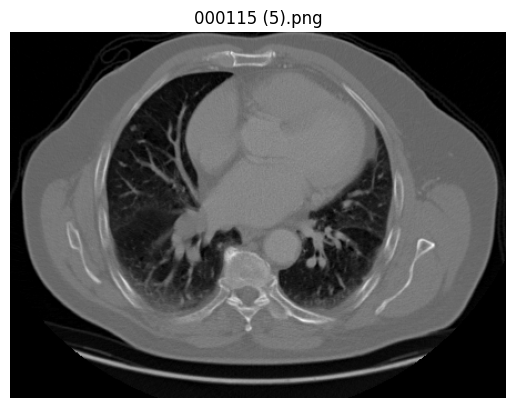

In [ ]:
print(images.keys()) #prints string representation of dict_keys view object, which includes 'dict_keys' followed by list of keys

##Display example image

In [ ]:
# Condition checks if images { } is not empty; In Python, empty { } evaluates to False, non-empty { } evaluates to True
if images:
    example_key = next(iter(images))  # Get first key in { }
                                      # iter(images) creates iterator over { } keys
                                      # next(iter(images)) retrieves 1st key from iterator to get one example image from { } to display
    plt.imshow(images[example_key])   # Uses Matplotlib to display image associated with example_key
                                      # Value corresponding to example_key in images { } is image data (NumPy array representing image in RGB format)
    plt.axis('off')                   # Turn off axis: turns off labels and ticks, make display cleaner by removing coordinate system
    plt.title(example_key)            # Display image file name as title: sets plot title to value of example_key, image filename, to identify image displayed
    plt.show()                        # Displays plot with image
else:
    print("No images found in the specified directory structure.")

##Set up directory paths for train, test, and valid using os.path.join() based on base directory, base_dir

In [ ]:
# Use os.path.join() to concatenate base_dir and 'train', set train_dir to 'Data/train'
train_dir = os.path.join(base_dir, 'train')
          # os.path.join(base_dir, 'train') takes base_dir, which = 'Data/', and concatenates with string 'train'

# Concatenate base_dir and 'test', set test_dir to 'Data/test'
test_dir = os.path.join(base_dir, 'test')
        # os.path.join(base_dir, 'test') takes base_dir, which = 'Data/', and concatenates with string 'test'

# Concatenate base_dir and 'valid', set valid_dir to 'Data/valid'
valid_dir = os.path.join(base_dir, 'valid')
          # os.path.join(base_dir, 'valid') takes base_dir, which = 'Data/', and concatenates with string 'valid'

### List base_dir directory folders to see their arrangement

In [ ]:
#Read contents of base_dir and return list of names of entries (files and directories) in it
os.listdir(base_dir)

['valid',
 'test',
 'train',
 'second_model.keras',
 'ensemble_model.keras',
 'chained_model.keras',
 'first_model.keras']

 Use tf.keras.preprocessing.image_dataset_from_directory (tf alias for TensorFlow module) to create training_set, testing_set, validation_set

image_dataset_from_directory method automatically labeles images based on subdirectory names  
Each subdirectory treated as class, labels assigned as integers starting at 0  
Method converts string labels to integers based on alphabetical order, becauset label_mode='int'

In [ ]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(224, 224),
batch_size=32,
label_mode='int'  # to work with sparse labels (not categorical, e.g. one-hot encoded vectors) set label_mode parameter to 'int'
    )

testing_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(224, 224),
batch_size=32,
label_mode='int' # implies eventual use of SparseCategoricalCrossentropy loss function, not CategoricalCrossentropy
    )

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
valid_dir,
seed=101,
image_size=(224, 224),
batch_size=32,
label_mode='int'
    )

Found 613 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


##Use tf.keras.Input and tf.keras.layers to build first_model with Functional API  
Data augmentation, rescaling, and use of ResNet50 model don't automatically imply model has nonlinear data flow, but they do indicate non-sequentail flow and need for explicit control over data flow.   
  
first_model's layers are like functions  
Each layer takes input tensor and returns output tensor  
Also, use of pre-trained model that expects input connections means insertion of large piece of archictecture into pipeline  Sequential API does not allow for plugging in exernal models     
  
Pre-trained models aren't complete models, but blocks of layers that need to be wired into larger models. Pre-trained models need to be explicity connected to input, often using Functional API.   

Most pre-trained models designed to be used as feature extractors or base for fine tuning  
Setting include_top=False tells model that what goes before and after it will be explicitly defined (input tensor and output layers)    

Sequential API does not allow for input injection, branching, or routing around or into a pre-trained model         

Define Input(shape=   ) to tell Keras how input looks  
Input(shape=    ) is Keras functional API layer that creates symbolic placeholder (tensor) to represent model's input    
  
Symbolic placeholder created by Input(...) layer, not by shape=... itself  

shape itself is just metadata; shape=(224,224,3) is description of input's dimensions    
Shape passed into Input() function so Keras knows a) what input size will be at each layer, and b) how to wire up computation graph  
Shape alone doesn't create anything in model; Input() layer turns it into real, usable symbolic object  

Think of Input(shape=   ) as model entry point  
Input(shape=...) is Keras layer that creates symbolic input tensor (placeholder in model graph)  
input_layer = Input(shape=224,224,3)  
shape tells Input() layer what to build, but Input() layer itself contructs model input placeholder    

In [ ]:
# Build first_model, ResNet50-based model, using Functional API

# Specify img_size, channels, img_shape, and class_count before defining model and data pipeline
img_size = (224, 224)     # what ResNet50 expects
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(training_set.class_names)

# Input tensor defines shape and structure of input data for model (raw image data from dataset)
# With Functional API, define input tensor with Input(); No need to define explicit input layer
input_tensor = Input(shape=(224, 224, 3))

# Define data augmentation layers directly from tf.keras.layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2) ])

# Apply data augmentation to input tensor, store results in 'augmented_inputs'
augmented_inputs = data_augmentation(input_tensor)

# Apply rescaling to normalize images' pixel values before feeding images to ResNet50 layers
# '(augmented_inputs)' in Rescaling layer necessary
# In Functional API we explicitly define data flow between layers by passing output of one as input to next
scaled_inputs = Rescaling(1./255)(augmented_inputs)

# Define ResNet50 base model with scaled_inputs instantiated as input tensor
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=scaled_inputs,
    pooling='max')  # base model will output tensor with shape (batch_size, channels), compatible with subsequent Dense layers

# Freeze layers of ResNet50 model to prevent them from being retrained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of base_model becuase ResNet50's final output layer not built for this custom task
x = base_model.output
x = BatchNormalization(axis=-1)(x)      # stabilizes and accelerates training by nomrmalizing activations
x = Dense(256, activation='relu')(x)    # adds nonlinear decision making capacity
x = Dropout(0.25)(x)                    # helps prevent overfitting by randomly disabling neurons during training

# Define output layer with number of classes because model to be direct ensembled
outputs = Dense(class_count, activation='softmax')(x)    # Dense layers w/softmax activation function outputs vector representing class probabilities for 4-class problem

# Build first_model by specifying inputs and outputs
# Because outputs variable represents model final output, use outputs = outputs when defining model using Model class
first_model = Model(inputs=input_tensor, outputs=outputs)   # Constructs Functional model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Print summary of model to check architecture
#first_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ rescaling[0][0]   │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 24,121,476 (92.02 MB)

 Trainable params: 529,668 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

##Optimize Model, Define File Path for saving model



In [ ]:
#Define optimizer
optimizer = Adam()

#base_dir already defined earlier as '/content/drive/MyDrive/Portfolio/Med_Imaging_CNN/Data'

# Define full file path including base directory
first_filepath = os.path.join(base_dir, 'first_model.keras')

##Define EarlyStopping and ModelCheckpoint callbacks  
  
During neural network training, model goes through multiple epochs. Model tries to improve in each epoch. Model performance evaluated on validation data (not training data), using val_accuracy as metric.   

If model starts to overfit (improves on training data but worsens on validation), it can eventaully get worse on both validation and training data. Best validation accuracy often happens before training ends. If EarlyStopping halts training without restore_best_weights=True, final model weights will be from last epoch - not necessarily the best-performing epoch. With restore_best_weights=True, model keeps track of epoch with highest val_accuracy during training.


In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
                                monitor='val_accuracy',
                                patience=20,               # Stop training after 20 epochs with no improvement in monitored metric (by default, validation loss)
                                restore_best_weights=True, # Ensure after training stops, model weights reverted to best state observed during training
                                verbose=1
                                )

# Create ModelCheckpoint callback to save maximum best model based on validation accuracy
checkpoint = ModelCheckpoint(first_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

##Compile, Train, Save First Model using sparse_categorical_crossentropy loss function, given multi-class classification tasks


In [ ]:
first_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train first model with added callbacks
history = first_model.fit(
    x=training_set,
    epochs=100,
    verbose=1,
    validation_data=validation_set,
    callbacks=[checkpoint, early_stopping]
)

# Save model in specified directory
first_model.save(first_filepath)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7207 - loss: 0.6627
Epoch 1: val_accuracy improved from -inf to 0.52778, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/first_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.7203 - loss: 0.6645 - val_accuracy: 0.5278 - val_loss: 0.9797
Epoch 2/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6906 - loss: 0.6612
Epoch 2: val_accuracy improved from 0.52778 to 0.56944, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/first_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.6913 - loss: 0.6651 - val_accuracy: 0.5694 - val_loss: 0.9383
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6938 - loss: 0.6776
Epoch 3: val_accuracy improved from 0.56944 to 0.58333, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/first_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/

##Define second_model, custom CNN, using Functional API (instead of Sequential API) because model contains Nonlinear layer connections

In [ ]:
# Define input shape and model parameters
img_size = (224, 224)       # Consistency with first_model
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(training_set.class_names)

# Define input tensor; with Functional API, define input tensor with Input()
# No need to define explicit input layer
input_tensor = Input(shape=img_shape)

# Apply data augmentation layers
x = RandomFlip("horizontal")(input_tensor)   # nonlinear layer
x = RandomRotation(0.2)(x)                   # nonlinear layer
x = RandomZoom(0.2)(x)                       # nonlinear layer

# Apply rescaling
x = Rescaling(1./255)(x)                     # linear transformation scaling pixel values by constant

# Define convolutional and pooling layers
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)    # nonlinear layer
x = MaxPooling2D(pool_size=(2, 2))(x)                               # nonlinear layer

x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)    # nonlinear layer
x = MaxPooling2D(pool_size=(2, 2))(x)                               # nonlinear layer

x = Dropout(0.25)(x)

x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)   # nonlinear layer
x = MaxPooling2D(pool_size=(2, 2))(x)      # After this layer, output tensor is 3D, incompatible with Dense layers

x = Dropout(0.25)(x)       # nonlinear (during training), introduces stochastic nonlinear behavior

# Flatten tensor because output is 3D tensor (height, width, channels) but subsequent Dense layers expect
# 1D vector (flat array of features) as input, turn input shape (26, 26, 64) into Output shape (26 × 26 × 64 = 43264)
x = Flatten()(x)

# Add Dense layers
x = Dense(128, activation='relu')(x)        # Relu and Softmax are nonlinear
x = Dropout(0.25)(x)

# Output layer can't interpret spatial dimensions of tensor, only operates on 1D feature vectors (flat arrays)
outputs = Dense(class_count, activation='softmax')(x)

# Define model
second_model = Model(inputs=input_tensor, outputs=outputs)

# Print model summary
#second_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,567,076 (21.24 MB)

 Trainable params: 5,567,076 (21.24 MB)

 Non-trainable params: 0 (0.00 B)

##Optimize Second Model, Define Path to Save Model



In [ ]:
#Define optimizer
optimizer = Adam()

# base_dir already defined earlier as '/content/drive/MyDrive/Portfolio/Med_Imaging_CNN/Data'

# Define full file path including base directory
second_filepath = os.path.join(base_dir, 'second_model.keras')

##Define EarlyStopping and ModelCheckpoint callbacks



In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save maximum best model based on validation accuracy
checkpoint = ModelCheckpoint(second_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

##Compile, Train, Save Second Model using sparse_categorical_crossentropy loss function, given multi-class classification tasks


In [ ]:
# Compile second_model
second_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#train model
history = second_model.fit(
    x=training_set,
    validation_data=validation_set,
    epochs=100,
    callbacks=[early_stopping, checkpoint],  # Include both callbacks
    verbose=1
)

# Save model to specified filepath
second_model.save(second_filepath)

Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2671 - loss: 1.9828
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/second_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2663 - loss: 1.9487 - val_accuracy: 0.4583 - val_loss: 1.3683
Epoch 2/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3251 - loss: 1.3080
Epoch 2: val_accuracy improved from 0.45833 to 0.48611, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/second_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3257 - loss: 1.3074 - val_accuracy: 0.4861 - val_loss: 1.2379
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4361 - loss: 1.2109
Epoch 3: val_accuracy did not improve from 0.48611
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4374 - loss: 1.2093 - val_accuracy: 0.4028 - val_loss: 1.0470
Epoch 4/100
19/20 ━━━━━━━━━━

##Model Ensembling in Deep Learning: Averaging Submodels' Predictions in two-stage stacked ensemble

In [ ]:
#Load first_model and second_model from saved .keras

# How full file paths, including base directory, were deined
#first_filepath = os.path.join(base_dir, 'first_model.keras')
#second_filepath = os.path.join(base_dir, 'second_model.keras')
first_model = load_model(first_filepath)
second_model = load_model(second_filepath)

### Extract labels from TensorFlow datasets so ensemble_model has labels to compute loss and update model during training  
In tf.data.Dataset object, each element is batch_images, batch_labels tuple  
batch_labels is TensorFlow tensor (shape 32,  ) for each batch of 32 labels  

get_labels function extracts labels from a dataset by:  
1) Iterating over dataset, where batch_labels contains labels for batch of images  
2) Converting each batch of labels from TensorFlow tensors into NumPy arrays using .numpy()  
3) Appending each NumPy array to list named 'labels'  
4) After processing all batches, using np.concatenate(labels, axis=0) to merge all label arrays into single NumPy array (1D or 2D depending on label shape)  
Result is one unified array containing all labels from dataset

The y_train, y_val, and y_test arrays extracted contain sparse integer labels, like:
[2, 0, 1, 4, 3, 2, 1, ...]  # shape: (num_samples,), dtype: int

In [ ]:
import numpy as np

def get_labels(dataset):
    labels = []
    for _, batch_labels in dataset:
                                             # _ used to ignore image data since only interested in labels
        labels.append(batch_labels.numpy())
    return np.concatenate(labels, axis=0)

# Extract labels
y_train = get_labels(training_set)          # y_train will contain all labels from training_set
y_test = get_labels(testing_set)            # y_test will contain all labels from testing_set
y_val = get_labels(validation_set)          # y_val will contain all labels from validation_set

###Generate prediction probabilities from training and validation datasets to combine outputs of individual models
  
  Neural network classifiers (e.g., image classifiers) typically output softmax probabilities as vector like  [0.05, 0.01, 0.92, 0.02]  
    
  When ensembling models, combine what each model believes about each class  
      - Beliefs best expressed as class probabilities, not final class label (argmax)  
      -  Full probability vector needed for each sample so it can be averaged meaninfully across models  
      - Probability outputs offer model richer signal to learn from than class labels  
         final_probs = (model1_probs + model2_probs) / 2   
      - Probabilities retain model's confidence and distribution over all classes  
      - Otherwise, final predicted classes are argmax decisions which discard uncertainty info  
         final_prediction = np.argmax(final_probs, axis=1)   
      - Ensembling class labels (voting) much less powerful than combining full probability distributions  

Training models does not generate or save models' predictions  
Explicitly call .predict() or .evaluate() to generate outputs from trained models on new input data  
During model training, Keras does not save or return actual prediction vectors per sample (like [0.01, 0.3, 0.6]  
Predictions computed internally and discarded after each batch; not saved unless explicity requested

In Python, variable names like preds_first_model_val and
preds_second_model_val refer to NumPy arrays containing actual prediction values, not to symbolic placeholders (layers that will accept data shaped like predictions)

In [ ]:
#Generate Prediction Probabilities from Submodels with shape (None, 4)

# Generate predictions for training set
preds_first_model_train = first_model.predict(training_set)
preds_second_model_train = second_model.predict(training_set)

# Generate predictions for validation set
preds_first_model_val = first_model.predict(validation_set)
preds_second_model_val = second_model.predict(validation_set)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


training_set and validation_set are tf.data.Datasets built with image_dataset_from_directory  
  
batched tf.data.Dataset yields (images, labels) per batch  
   
each image batch has shape (32, 224, 224, 32)  
each label batch has shape (32, ), with integer class labels (sparse labels)  
  
preds_first_model_train = first_model.predict(training_set) internally loops over dataset and collects predictions into full NumPy array  
  
using training_set lets TensorFlow handle batching, shuffling, prefetching, iteration over epochs

Predictions shaped like (num_samples, num_classes) and represent class probabilities (softmax outputs).

Labels (y_val, etc.) shaped like (num_samples,) and contain class indices (int) — which is what sparse_categorical_crossentropy expects.

## SCENARIO A: Average Submodels' Outputs Outside of ensemble_model

 ensemble_input = (preds_first_model + preds_second_model) / 2  
ensemble_input = [0.075, 0.075, 0.775, 0.075]  

In [ ]:
# Average predictions from both models for 'training set'
ensemble_input_train = (preds_first_model_train + preds_second_model_train) / 2

# Average predictions from both models for 'validation set'
ensemble_input_val = (preds_first_model_val + preds_second_model_val) / 2

### Define EarlyStopping and ModelCheckpoint Callbacks and new filepath to save ensemble_model

In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save maximum best ensemble_model based on validation accuracy
checkpoint = ModelCheckpoint(ensemble_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define new file path to save ensemble_model
ensemble_filepath = os.path.join(base_dir, 'ensemble_model.keras')

###Build, compile, train model to process combined (averaged) predictions  
When averaging outputs, input shape to ensemble_model will reflect how outputs get combined  
Resulting shape remains (None, 4), combining 2 predictions per class  
ensemble_input = [0.075, 0.075, 0.775, 0.075]  Vector still (1x4), ie., softmax scores for 4 classes   
Input shape to ensemble_model is (NumSamples, NumClasses), e.g., (1000, 4)  

Averaged softmax probabilities become features for ensemble model  
Treat 4 softmax scores per sample as input features to ensemble model  
ensemble_model is learning a meta-classifier that takes averaged confidence per class and makes final prediction  
input layer will look like Input(shape=(4, 0) to reflect 4 class probabilities averaged from two submodels  

Not stacking raw features but combining post-softmax predictions (model's confidence scores per class) and training new model to interpret them  
ResNet50-based and CNN models learned different decision boundaries  
Meta-model callibrates/arbitrates based on outputs, another softmax vector over 4 classes  

In [ ]:
# Build ensemble_model that takes already-averaged submodels' ouputs as input

#1) Define input tensor for ensemble_model (shape corresponds to 4 classes)
ensemble_input_tensor = Input(shape=(4,))

#2) Add dense layer
# keep output shape of ensemble_model consistent with original problem
final_output = Dense(4, activation='softmax')(ensemble_input_tensor)  # 4-class classification problem

#3) Define ensemble model
ensemble_model = Model(inputs=ensemble_input_tensor, outputs=final_output)


# Compile ensemble model
ensemble_model.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])


# Train ensemble model on averaged predictions
history = ensemble_model.fit(                      # Keras fit method trains model for fixed # of epochs using provided training data and labels
                                                   # Returns history object with loss & accuracy values at each epoch
    x=ensemble_input_train,                        # specifies input data to train ensemble_model: averaged predictions from submodels with shape (None, 4)
    y=y_train,                                     # Use same labels from original dataset to specify labels for training data; y_train represents true labels
    validation_data=(ensemble_input_val, y_val),   # ensemble_input_val contains averaged predictions from submodels on validation set; y_val contains true labels
    epochs=100,
    callbacks=[early_stopping, checkpoint],
    verbose=1                                      # detailed progress of each epoch, loss, accuracy, validation metrics displayed in output
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2277 - loss: 1.4678  
Epoch 1: val_accuracy did not improve from 0.68056
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2285 - loss: 1.4673 - val_accuracy: 0.2361 - val_loss: 1.4571
Epoch 2/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3125 - loss: 1.4635
Epoch 2: val_accuracy did not improve from 0.68056
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2423 - loss: 1.4544 - val_accuracy: 0.2361 - val_loss: 1.4508
Epoch 3/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2500 - loss: 1.4259
Epoch 3: val_accuracy did not improve from 0.68056
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2303 - loss: 1.4410 - val_accuracy: 0.2222 - val_loss: 1.4450
Epoch 4/100
 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3750 - loss: 1.3626
Epoch 4: val_accuracy did not improve from 0.68056
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2642 - loss: 1.4236 - val_accuracy: 0.2361 - val_lo

###Save ensemble_model in specified directory and display model summary

In [ ]:
# Save model in specified directory
ensemble_model.save(ensemble_filepath)

#Display ensemble model summary
ensemble_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62 (252.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42 (172.00 B)

### Averaging Outputs Outside Ensemble Model   
When averaging submodels' outputs outside ensemble model, ensemble model sees just one input: averaged predictions
ensemble_input_train = (preds_first_model_train + preds_second_model_train) / 2  
This averaging step non-trainable so doesn't learn how to weigh each submodel.  
Simpler, faster, less expressive method (assumes equal model importance) method avoids recomputing same predictions repeatedly.     
If submodels are large (e.g., ResNet50) and task is to run inference only (use trained model to make predictions on new data) it's more efficient to precompute predictions and average them outside of ensemble model.
  
###Averaging Outputs Inside Ensemble Model      
When averaging inside ensemble model, submodels' outputs pass separately to ensemble model for averaging or learning weights    
Averaging becomes part of model architecture.  
(A) If averaging step inside ensemble is fixed (unweighted) average, step not trainable  
(B) Can replace Average() with Concatenate() to let trainable dense layer learn how to weigh each submodel's predictions.   
Ensemble model becomes trainable only if incudes trainable parameters (e.g., Dense layer) after or instead of averaging  
Dense, trainable layer lets ensemble model learn from both submodels' full outputs  
Useful if one submodel better at classifying one class, and other submodel better at classifying another class  
   
Concatenate() is layer that joins tensors along specific axis.   
Takes input1 and input2, both probability vectors of shape:(4, ) and produces combined output proability vector of shape:(8, ).   
Combined vector passed to trainable Dense layer, which learns to combine and interpret submodels' outputs together.    
input1 = Input(shape=(4,))  
input2 = Input(shape=(4,))  
merged = Concatenate()([input1, input2])  # shape becomes (8,)  
output = Dense(4, activation='softmax')(merged)  
ensemble_model = Model(inputs=[input1, input2], outputs=output)  
Concatenate() takes submodels' full prediction vectors and stacks them into one longer vector that gets passed to trainable layer.   
This enables ensemble mode to learn a custom combination strategy.


## SCENARIO B: Average Submodels' Outputs Inside Ensemble Model, with NON-Trainable Averaging Layer

Create filepath for ensembleB_model and Model Checkpoint callback

In [ ]:
# Define new file path to save ensembleB_model
ensembleB_filepath = os.path.join(base_dir, 'ensembleB_model.keras')

# Define EarlyStopping callback for Scenario B ensemble model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save maximum best ensemble_model based on validation accuracy
checkpointB = ModelCheckpoint(ensembleB_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

When manually defining Keras model input layer, specify shape of 1 input sample, not batch (batch inferred automatically)
  
In ensemble model context:  
(a) Input(...) function creates symbolic tensor, not real data, telling Keras how model graph should begin and acts as placeholder for real inputs during training  
(b) Input sample is 1 prediction vector of shape (4, )  
(c) Batch is group of input samples/prediction vectors processed together at once; array that includes multiple samples     Ex: Batch of predictions of shape (32, 4) has 32 prediction and 4 classes

model.fit() expects model.fit(x,y) where x is single input or list/{} of multiple inputs and y is target labels  
  
When multiple inputs exist, group inputs together as single list/{} with (1) model.fit([x1, x2], y) as in ensembleB_model.fit([preds_first_model_train, preds_second_model_train], y_train) OR (2) with model.fit(x,y) such as ensemble_input_train = [preds_first_model_train, preds_second_model_train] and ensembleB_model.fit(ensemble_input_train, y_train)  

Keras:  Configures model for training, Tells model how to compute loss, Tells model how to update weights (optimizer), Tells models what metrics to track    
Without compilation, Keras has no idea: What “error” means (loss), How to score performance (accuracy), Whether training is even allowed

Average() doesn’t need trainable=False:
because Average layer is sinply mathematical operation  
Average() non-trainable because it doesn't have weights to update and there's nothing to train  
Average() is pointwise operation that doesn't expand shape

first_model ends with softmax activation and was trained for classification with 4 classes  
preds_first_model_train.shape == (num_samples, 4)  
  
shape[0] means num_samples (number of input samples)  
shape[1] means num_classes (number of predicted classes)  
shape[1:] means (num_classes, ) (a tuple, not an integer; invalid Input(shape=...)

Build, Compile, Train ensembleB_model



In [ ]:
# Build ensembleB_model with non-trainable averaging layer, using Functional API

#Determine number of classes for either submodel, since both share same number of classes
num_classes = preds_first_model_train.shape[1]

# Define symbolic inputs to ensembleB_model (first_model's and second_model's training predictions)
input_1 = Input(shape=(num_classes,))     # first symbolic placeholder to define model structure
input_2 = Input(shape=(num_classes,))     # second symbolic placeholder to define  model structure
averaged = Average()([input_1, input_2])  # Non-trainable averaging layer

Create Keras Model object that defines computational graph with 2 inputs and 1 output



In [ ]:
#Model object tells Keras input_1 and input_2 are model inputs and instructs how data should flow through network to produce output
ensembleB_model = Model(inputs=[input_1, input_2], outputs=averaged)   #Now ensembleB_model is fully functional model

Always compile model before feeding real data into it

In [ ]:
#Compile model because model will be trained and evaluated using .fit() and .evaluate() methods
ensembleB_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Feed real data into model at runtime, as part of model training, by creating a single list of two NumPy arrays (predictions)

In [ ]:
#ensemble_input_train is Python list of real NumPy arrays structured to match number & order of symbolic inputs
#makes training, evaluation possible by binding real values to symbolic inputs during .fit() or .evaluate()

#ensembleB_model.fit(ensemble_input_train, y_train) passes list of NumPy arrays to model, where Keras feeds preds_first/second_model_train into input_1/input_2
ensemble_input_train = [preds_first_model_train, preds_second_model_train]   # preds_first/second_model_train are actual softmax predictions

#ensemble_input_train is list of two arrays
ensembleB_model.fit(ensemble_input_train, y_train)    #target (y_train) is same target used to train original model

In [ ]:
# Evaluate model on validation predictions
ensembleB_model.evaluate([preds_first_model_val, preds_second_model_val], y_val)

##SCENARIO C: Average Submodels' Outputs Inside Ensemble Model with Trainable Dense Layer

Create filepath for ensembleC_model and Model Checkpoint callback

In [ ]:
# Define new file path to save ensembleB_model
ensembleC_filepath = os.path.join(base_dir, 'ensembleC_model.keras')

# Define EarlyStopping callback for Scenario B ensemble model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save maximum best ensemble_model based on validation accuracy
checkpointC = ModelCheckpoint(ensembleC_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

Build Symbolic Model

averaged = Average()([input_1, input_2]) computes element-wise mean of 2 input vectors  
Result is single vector of shape (4,) (still 4 values, one per class)   
Because is fixed operation, layer is non-trainable  
  
output = Dense(4, activation="softmax")(averaged) passes 4-dimensional averaged predicton vector to trainable Dense layer  
Dense layer applies learnable linear transformation (W * x + b) followed by softmax activation (trainable transformation of averaged predictions)   
Model not doing weighted average but average + learnable post-processing   

In [ ]:
#Determine number of classes for either submodel, since both share same number of classes
num_classes = preds_first_model_train.shape[1]

# Define symbolic inputs (each is prediction vector of shape (4,))
input_1 = Input(shape=(num_classes,))
input_2 = Input(shape=(num_classes,))

# Average both prediction vectors
averaged = Average()([input_1, input_2])

# Pass averaged predictions through trainable Dense layer (learns how to reweight averaged predictions)
output = Dense(num_classes, activation='softmax')(averaged)


Create Keras Model object that defines computational graph with 2 inputs and 1 output

In [ ]:
# Define ensemble model
ensembleC_model = Model(inputs=[input_1, input_2], outputs=output)

Compile ensembleC_model

In [ ]:
#Compile ensemble model
ensembleC_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'

Train ensembleC_model

In [ ]:
ensemble_model.fit([preds_first_model_train, preds_second_model_train], y_train)

Evaluate ensembleC_model

In [ ]:
# Evaluate on validation predictions
ensembleC_model.evaluate([preds_first_model_val, preds_second_model_val], y_val)

##SCENARIO D: Concatenate Submodels' Outputs Inside Ensemble Model with Trainable Dense Layer

In [ ]:
# Define new file path to save ensembleB_model
ensembleD_filepath = os.path.join(base_dir, 'ensembleD_model.keras')

# Define EarlyStopping callback for Scenario B ensemble model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save maximum best ensemble_model based on validation accuracy
checkpointD = ModelCheckpoint(ensembleD_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
#Determine number of classes for either submodel, since both share same number of classes
num_classes = preds_first_model_train.shape[1]

# Define symbolic inputs (each is prediction vector of shape (4,))
input_1 = Input(shape=(num_classes,))
input_2 = Input(shape=(num_classes,))

# Average both prediction vectors
concatenated = Concatenate()([input_1, input_2])         #Shape wil be (8,)

#8-dimensional vector fed to Dense layer, which learns more flexible, expressive mapping to final class probabilities
# Pass averaged predictions through trainable Dense layer (learns how to reweight averaged predictions)
output = Dense(4, activation='softmax')(concatenated)    #Shape will be (4,)

Create Keras Model object that defines computational graph with 2 inputs and 1 output

In [ ]:
# Define ensemble model
ensembleD_model = Model(inputs=[input_1, input_2], outputs=output)

Compile ensembleD_model

In [ ]:
#Compile ensemble model
ensembleD_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer='adam'

Train ensembleD_model

In [ ]:
ensemble_model.fit([preds_first_model_train, preds_second_model_train], y_train)

Evaluate ensembleD_model

In [ ]:
# Evaluate on validation predictions
ensembleD_model.evaluate([preds_first_model_val, preds_second_model_val], y_val)

#Chaining first_model and second_model

When chaining two models, specify data augmentation and rescaling only in first model  
Create modified versions of first_model and second_model compatible for chaining

Possible to use Sequential model (like data augmentation) inside Functional API model because Sequential models are specialized Model objects and Functional models are fully composable  
Defining data augmentation with Sequential API creates Model object that acts  like layer  
data_augmentation is callable object that takes tensor and returns tensor  
Functional API layers and models are symbolic, computational graph preserved  
Sequential model like a mini pipeline of layers that can be plugged into larger graph created with Functional API  
Sequential models are subclassed from Model and behave like layers

Computational graph is abstract blueprint of which operations (Dense, Activation, Average) performed in what order, applied to what inputs, and producing what output  
TnesorFlow uses computational graph to optimize model during training

If data_augmentation is function that returns Keras Sequential model or layer stack containing agumentation layers, calling the function invokes those layers on the input

Keras stores:  
mod_first_model.input = symbolic tensor input_tensor  
mod_first_model.output = symbolic tensor output_tensor  
  
input_tensor = Input(shape=(224, 224, 3)) tells Keras that model will expect one input sample with shape (224, 224, 3) (a single image)  

mod_first_model.input is defined as symbolic placeholder, not real data  
defines input shape and acts as starting node in model's computational graph      
  
Feed real data later, during .fit(), .evaluate(), or .predict()  

In [ ]:
#Define but don't train modified version of first_model, mod_first_model

# Specify img_size, channels, img_shape, and class_count before defining model and data pipeline
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(training_set.class_names)

# Define necessary input tensor for Keras model
input_tensor = Input(shape=(224, 224, 3))

# Define data augmentation layers directly from tf.keras.layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# Apply data augmentation to input tensor, store results in 'augmented_inputs'
augmented_inputs = data_augmentation(input_tensor)

# Apply rescaling to normalize images' pixel values before feeding images to ResNet50 layers
# Include (augmented_inputs) in Rescaling layer: Pass (augmented_inputs) as input so model knows where to apply rescaling
scaled_inputs = Rescaling(1./255)(augmented_inputs)

# Define ResNet50 base model with scaled_inputs as input tensor
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=scaled_inputs,
    pooling='max')    # base model to output tensor with shape (batch_size, channels), compatible with subsequent Dense layers
                      # Without pooling='max', ResNet50 outputs feature map of shape (7, 7, 2048) after convolutional layers
                      # Global max pooling reduces 7x7 feature map to shape (batch_size, 2048) because feature map reduced to single max value for each channel

# Freeze layers of ResNet50 model to prevent them from being retrained
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of base_model
x = base_model.output
x = BatchNormalization(axis=-1)(x)
x = Dense(256, activation='relu')(x)      # This layer takes 2048-dimensional output and produces 256-dimensional vector
x = Dropout(0.25)(x)

# Remove final Dense layer with softmax activation function as output because it outputs vector representing class probabilities
# outputs = Dense(class_count, activation='softmax')(x)

# Define new output layer for feature extraction: no output layer needed for feature extraction so use x as output
# output is result of Dropout layer, which has shape (batch_size, 256), given how preceding Dense layer defined
mod_first_model_output = x

# Define mod_first_model as feature extractor model
mod_first_model = Model(inputs=input_tensor, outputs=x)     # Use 'inputs' here to include entire pipeline

#model summary
#mod_first_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 24,120,448 (92.01 MB)

 Trainable params: 528,640 (2.02 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

Use case for .output:  
Used when building ensemble models or model chaining  
Used for model introspection/debugging print(model.output.shape)  

Symbolic Tensor represents output of model, given input  
Symbolic Tensor can be Feature Vector if mod_first_model ends in global average pooling or flattening  


Feature Vector is 1D array (vector) of numerical values that represent input, image, or object  
Typically comes from intermediate or final layer of neural network  
Used for classification, similarity comparison, clustering, input to another model

Output Tensor produced by model (or any layer) when given input  
Could be feature vector, probability distribution (softmax output), logit vector, multi-dimensional image  
Feature Vector is type of Output Tensor, but not all Output Tensors are Feature Vectors

In [ ]:
#Define but don't train modified version of second_model, mod_second_model

# Define output of mod_first_model
# Given model's defined input, what model will product after passing data through all layers
x = mod_first_model.output      # 'mod_first_model' is Keras Model object feature extractor model
                                # 'output' is symbolic tensor representing output of model's computational graph

#Specify number of classes in dataset
class_count = len(training_set.class_names)

# Define input tensor to match shape of mod_first_model output
input_tensor = Input(shape=(256, ))

# Data augmentation and rescaling not needed here; already present in mod_first_model
# x = RandomFlip("horizontal")(input_tensor)
# x = RandomRotation(0.2)(x)
# x = RandomZoom(0.2)(x)
# x = Rescaling(1./255)(x)

# Dropout, convolutional, and pooling layers already included in mod_first_model
#x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.25)(x)
#x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Dropout(0.25)(x)

# Flatten layer unnecessary since mod_first_model generated compatible shape
# x = Flatten()(x)

# Build remaining layers using Functional API
x = Dense(256, activation='relu')(input_tensor)
x = Dropout(0.25)(x)

# Output layer
mod_second_model_output = Dense(class_count, activation='softmax')(x)

# Define model
mod_second_model = Model(inputs=input_tensor, outputs=mod_second_model_output)

# Print model summary to verify
mod_second_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,820 (261.02 KB)

 Trainable params: 66,820 (261.02 KB)

 Non-trainable params: 0 (0.00 B)

Feature Vector is 1D array of numerical values that represent input, image, or object  
typically comes from intermediate or final layer of neural network (can be intermediate output tensor)  
can be used for classification, similarity comparison, clustering, input to another model  
is type of output tensor, but not all output tensors are feature vectors  
feature vector and output tensor are both tensors, but only feature vector commonly used for further ML tasks  

Output Tensor is final tensor produced by model or any layer when given an input  
could be a feature vector, probability distribution, logit vector, multi-dimensional image (for segmentation or image generation)

Symbolic Tensors represent output of model given its input; can be held by variables, especially with Functional API  
are placeholders for data rather than real data like NumPy arrays or prediction results   
represent whatever will come out of model once real data flows through it   
used when building model (in Functional API)  
don’t carry data yet but have dedined shape and data type and define structure of computational graph  
are created when building model using Input() or layer calls like Dense(..)()  
become real tensors when running .fit(), .predict(), or .evaluate()  

In [ ]:
#CHAIN mod_first_model and mod_second_model

#(1) Define 'mod_first_model_output' as variable to hold feature vector output from mod_first_model
mod_first_model_output = mod_first_model.output
#Feature vector (variable) = Keras Model object.Symbolic tensor representing model's computational graph output

#(2) Define 'mod_second_model_output' as variable to hold output from mod_second_model, whose input is mod_first_model_output
#(3) Pass feature vector to mod_second_model for further processing to become classification probabilities
mod_second_model_output = mod_second_model(mod_first_model_output)

#Define new Keras model called chained_model that chains mod_first_model and mod_second_model into single model
chained_model = Model(inputs=mod_first_model.input, outputs=mod_second_model_output)

                      #inputs=mod_first_model.input specifies input to chained_model = input to mod_first_model
                      #mod_first_model.inputs already defined inside model, when mod_first_model originally built

                      #outputs=mod_second_model_output defines chained_model's output taken from result of mod_second_model_output,
                      #which was output of mod_second_model after passing feature vector from mod_first_model

#chained_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ sequential_1[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 24,187,268 (92.27 MB)

 Trainable params: 595,460 (2.27 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [ ]:
#Compile model
optimizer = Adam()
chained_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define full file path including base directory
chained_filepath = os.path.join(base_dir, 'chained_model.keras')

In [ ]:
#Define EarlyStopping and ModelCheckpoint callbacks

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1)

# Create ModelCheckpoint callback to save best model based on validation accuracy
checkpoint = ModelCheckpoint(chained_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
print(mod_first_model.output.shape)

In [ ]:
# Train chained model with added callbacks
history = chained_model.fit(
    x=training_set,
    epochs=100,
    verbose=1,
    validation_data=validation_set,
    callbacks=[checkpoint, early_stopping]
)

chained_model.save(chained_filepath)  # Saves in specified directory

Epoch 1/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4687 - loss: 1.2769
Epoch 1: val_accuracy improved from -inf to 0.29167, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/chained_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - accuracy: 0.4739 - loss: 1.2685 - val_accuracy: 0.2917 - val_loss: 1.2940
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5120 - loss: 1.0758
Epoch 2: val_accuracy improved from 0.29167 to 0.47222, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/chained_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5133 - loss: 1.0750 - val_accuracy: 0.4722 - val_loss: 1.6536
Epoch 3/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5675 - loss: 1.0162
Epoch 3: val_accuracy improved from 0.47222 to 0.50000, saving model to /content/drive/MyDrive/BOOTCAMP/ColabNotebooks/ProjectWithGreg/Data/chained_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 

## Model Evaluation  
  
Colab and Jupyter Notebooks don't persist variables (like filepaths) accross sessions or after a kernel restart. If notebook was closed, runtime disconneted, or kernel restarted, all variables are gone and NameErrors arise unless variables redefined. Model object in memory (first_model) must also be reloaded after a kernel restart, notebook close, or runtime disconnect.   

In [ ]:
#Load models from saved .keras

# Define full file path, including base directory, when loading models saved in a nested directory
first_filepath = os.path.join(base_dir, 'first_model.keras')
second_filepath = os.path.join(base_dir, 'second_model.keras')
ensemble_filepath = os.path.join(base_dir, 'ensemble_model.keras')
chained_filepath = os.path.join(base_dir, 'chained_model.keras')

first_model = load_model(first_filepath)
second_model = load_model(second_filepath)
ensemble_model = load_model(ensemble_filepath)
chained_model = load_model(chained_filepath)

In [ ]:
# Evaluate and store metrics for first_model
first_model_train_loss, first_model_train_acc = first_model.evaluate(training_set)
first_model_val_loss, first_model_val_acc = first_model.evaluate(validation_set)
first_model_test_loss, first_model_test_acc = first_model.evaluate(testing_set)

print(f"First model training - Loss: {first_model_train_loss}, First model training - Accuracy: {first_model_train_acc}")
print(f"First model validation - Loss: {first_model_val_loss}, First model validation - Accuracy: {first_model_val_acc}")
print(f"First model testing - Loss: {first_model_test_loss}, First model testing - Accuracy: {first_model_test_acc}")

In [ ]:
# Evaluate and store metrics for second_model
second_model_train_loss, second_model_train_acc = second_model.evaluate(training_set)
second_model_val_loss, second_model_val_acc = second_model.evaluate(validation_set)
second_model_test_loss, second_model_test_acc = second_model.evaluate(testing_set)

print(f"Second model training - Loss: {second_model_train_loss}, Second model training - Accuracy: {second_model_train_acc}")
print(f"Second model validation - Loss: {second_model_val_loss}, Second model validation - Accuracy: {second_model_val_acc}")
print(f"Second model testing - Loss: {second_model_test_loss}, Second model testing - Accuracy: {second_model_test_acc}")

In [ ]:
# Generate Predictions for ensemble_model, which requires predictions from first_model and second_model on testing_set
# (Predictions for first_model and second_model on training_set and validation_set already completed in earlier step)

# Generate predictions from first_model and second_model on testing_set (unseen data)
preds_first_model_test = first_model.predict(testing_set)
preds_second_model_test = second_model.predict(testing_set)

# Average predictions from both models
ensemble_predictions_train = (preds_first_model_train + preds_second_model_train) / 2
ensemble_predictions_val = (preds_first_model_val + preds_second_model_val) / 2
ensemble_predictions_test = (preds_first_model_test + preds_second_model_test) / 2

# Create variables for train_ensemble_loss/accuracy, valid_ensemble_loss/accuracy, and test_ensemble_loss/accuracy
# by evaluating ensemble_model using ensemble predictions and true labels and storing values in variables

# Evaluate ensemble model on training set predictions and true labels
##Don't use this statement: ensemble_train_loss, ensemble_train_accuracy = ensemble_model.evaluate(ensemble_predictions_train, y_train)
##Because ensemble_model.evaluate() expects a model input, not predicted probabilities

from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
# Accuracy
acc_fn = CategoricalAccuracy()
acc_fn.update_state(y_train, ensemble_predictions_train)
ensemble_train_accuracy = acc_fn.result().numpy()
# Loss
loss_fn = CategoricalCrossentropy()
ensemble_train_loss = loss_fn(y_train, ensemble_predictions_train).numpy()

print(f"Ensemble model training - Loss: {ensemble_train_loss}, Ensemble model training - Accuracy: {ensemble_train_accuracy}")

# Evaluate ensemble_model on validation set predictions and true labels
ensemble_val_loss, ensemble_val_accuracy = ensemble_model.evaluate(ensemble_predictions_val, y_val)
print(f"Ensemble model validation - Loss: {ensemble_val_loss}, Ensemble model validation - Accuracy: {ensemble_val_accuracy}")

# Evaluate ensemble model on testing set predictions and true labels
ensemble_test_loss, ensemble_test_accuracy = ensemble_model.evaluate(ensemble_predictions_test, y_test)
print(f"Ensemble model training - Loss: {ensemble_test_loss}, Ensemble model training - Accuracy: {ensemble_test_accuracy}")



20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8138 - loss: 0.4545
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6497 - loss: 0.8958
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4671 - loss: 1.1192
First model training - Loss: 0.508497416973114, First model training - Accuracy: 0.8009787797927856
First model validation - Loss: 0.8692761659622192, First model validation - Accuracy: 0.6666666865348816
First model testing - Loss: 1.0715261697769165, First model testing - Accuracy: 0.4888888895511627
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6013 - loss: 0.8870
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6832 - loss: 0.8596
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4546 - loss: 1.1265
Second model training - Loss: 0.8845035433769226, Second model training - Accuracy: 0.6117455363273621
Second model validation - Loss: 0.8213175535202026, Second model validation - Accuracy: 0.6944444179534912
Second model testing - Loss: 1.141795754432678

In [ ]:
# Evaluate and store metrics for chained_model
chained_model_train_loss, chained_model_train_acc = chained_model.evaluate(training_set)
chained_model_val_loss, chained_model_val_acc = chained_model.evaluate(validation_set)
chained_model_test_loss, chained_model_test_acc = chained_model.evaluate(testing_set)

print(f"Chanied model training - Loss: {chained_model_train_loss}, Chained model training - Accuracy: {chained_model_train_acc}")
print(f"Chained model validation - Loss: {chained_model_val_loss}, Chained model validation - Accuracy: {chained_model_val_acc}")
print(f"chained model testing - Loss: {chained_model_test_loss}, Chained model testing - Accuracy: {chained_model_test_acc}")

##Model Results, Tabulated

In [ ]:
import pandas as pd
from tabulate import tabulate

# Define accuracy and loss values in dictionary with lists as values, to store data in tabular format, where each key represents
# column name (e.g., "Model", "Train Loss", "Train Accuracy") and corresponding list represents values for columns across rows

# Lists align with DataFrame structure, where each list corresponds to one column, allowing for easy conversion into tabular format
# like pandas DataFrame using pd.DataFrame(data)
# Ideal for storing data to be visualized or analyzed as table (e.g., using pandas for statistical operations or plotting)
# dictionary with lists representing columnar data facilitates conversion to tabular format

data = {
    "Model": ["first_model", "second_model", "ensemble_model", "chained_model"],
    "Train Loss": [first_model_train_loss, second_model_train_loss, ensemble_train_loss, chained_model_train_loss],
    "Train Accuracy": [first_model_train_acc, second_model_train_acc, ensemble_train_accuracy, chained_model_train_acc],
    "Validation Loss": [first_model_val_loss, second_model_val_loss, ensemble_val_loss, chained_model_val_loss],
    "Validation Accuracy": [first_model_val_acc, second_model_val_acc, ensemble_val_accuracy, chained_model_val_acc],
    "Test Loss": [first_model_test_loss, second_model_test_loss, ensemble_test_loss, chained_model_test_loss],
    "Test Accuracy": [first_model_test_acc, second_model_test_acc, ensemble_test_accuracy, chained_model_test_acc]
}

# Create pandas DataFrame
df = pd.DataFrame(data)

# Display table
df

# Convert DataFrame to Markdown
markdown_table = tabulate(df, headers='keys', tablefmt='pipe', showindex=False)
print(markdown_table)

In [ ]:
# Define models' loss and accuracy metrics
# Dictionary models_metrics contains model names= keys and nested dictionary =value, holding (train_loss/acc), (val_loss/acc), and (test_loss/acc) for each model
# Nested structure designed for quick, hierarchical access to individual model metrics, to directly retrieve metrics for specific model without needing to separate lists
# Nested dictionary better for storing key-value pairs for each model and associated metrics, enabling quick lookups like models_metrics["first_model"]["train_acc"]
# Reflects hierarchical relationship: outer keys represent models, inner keys represent metrics for each model
# Ideal for programmatic access to individual metrics for specific models during calculations (e.g., calculating composite scores, evaluating balance
# Use of nested dictionaries to represent hierarchical data making it easy to organize and retrieve metrics for each model programmatically

models_metrics = {
    "first_model": {"train_acc": first_model_train_acc, "val_acc": first_model_val_acc, "test_acc": first_model_test_acc},
    "second_model": {"train_acc": second_model_train_acc, "val_acc": second_model_val_acc, "test_acc": second_model_test_acc},
    "ensemble_model": {"train_acc": ensemble_train_accuracy, "val_acc": ensemble_val_accuracy, "test_acc": ensemble_test_accuracy},
    "chained_model": {"train_acc": chained_model_train_acc, "val_acc": chained_model_val_acc, "test_acc": chained_model_test_acc},
}

# Calculate composite score for each model by combining balance score and average accuracy
# Balance Score: Measures consistency of performance across training, validation, and testing sets
# Average Accuracy: Measures overall absolute performance of model

# Define calculate_composite_score function: just function definition, no calculations performed at this stage

def calculate_composite_score(models_metrics, w1=0.5, w2=0.5):   # w1, w2: Weights for combining balance score & average accuracy
    balance_scores = {}                                          # Initialize balance_scores: create empty dictionary to store balanced score for each model
    avg_acc_scores = {}                                          # Initialize avg_acc_scores: create empty dictionary to store average accuracy score for each model
    composite_scores = {}                                        # Initialize composite_scores: create empty dictionary to store composite score for each model

    for model_name, metrics in models_metrics.items():           # Loop through models: for each model_name, retrieve metrics (train_acc, val_acc, test_acc)
        # Extract accuracy values
        train_acc = metrics['train_acc']
        val_acc = metrics['val_acc']
        test_acc = metrics['test_acc']

        # Compute balance score: compute maximum gap between training, validation, and testing accuracies
        max_gap = max(abs(train_acc - val_acc), abs(val_acc - test_acc), abs(train_acc - test_acc))
        balance_score = 1 - max_gap      # smaller gap means a higher balance score

        # Compute average accuracy: Average accuracies across training, validation, and testing sets
        avg_accuracy = (train_acc + val_acc + test_acc) / 3

        # Composite score: Combine balance score and average accuracy using weights 𝑤1 and 𝑤2
        composite_score = w1 * balance_score + w2 * avg_accuracy

        # Store each model's balance_score results in balance_scores dictionary
        balance_scores[model_name] = balance_score
        # Store each model's avg_acc_score results in avg_acc_scores dictionary
        avg_acc_scores[model_name] = avg_accuracy
        # Store each model's composite_score result in composite_scores dictionary
        composite_scores[model_name] = composite_score

    # Return all three metrics
    return balance_scores, avg_acc_scores, composite_scores

balance_scores, avg_acc_scores, composite_scores = calculate_composite_score(models_metrics)

print(f"Balance Scores: {balance_scores}")
print(f"Average Accuracy Scores: {avg_acc_scores}")
print(f"Composite Scores: {composite_scores}")

# Combine all calculated metrics into dictionary of lists
aligned_metrics = {
    "Model": ["first_model", "second_model", "ensemble_model", "chained_model"],
    "Balance Score": list(balance_scores.values()),
    "Average Accuracy": list(avg_acc_scores.values()),
    "Composite Score": list(composite_scores.values()),
}

# Create DataFrame from aligned metrics
aligned_metrics_df = pd.DataFrame(aligned_metrics)

# Convert DataFrame to Markdown
from tabulate import tabulate
aligned_markdown_table = tabulate(aligned_metrics_df, headers='keys', tablefmt='pipe', showindex=False)
print(aligned_markdown_table)